In [ ]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd

import LE as le
import LP as lp
import iterative as iterative
import graph_vis as viz
import logger_creator

import graph_tools
import graph_gen

import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


# Small Graphs

In [ ]:
SEED = 0

range_x = range(0, 1001, 50)

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    delegations_orig, nodes = graph_gen.create_delegation_graph(num_nodes, seed=SEED)
    delegations= graph_tools.invert_graph(delegations_orig)

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)

    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if (powers_lp[node] - powers_iter[node] < 0.01):
            continue
        else: 
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break

    n = 50
    if 0 <= num_nodes < 500:
        n = 100
    elif 500 <= num_nodes < 1000:
        n = 100

    # LE
    start_time = time.time()
    le_model = le.set_up(delegations, nodes)
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    
    times_le.append((end_time - start_time) / n)

    # LP
    start_time = time.time()
    lp_model = lp.set_up(delegations, nodes)
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)
    
    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
        continue
    end_time = time.time()

    times_iterative.append((end_time - start_time) / n)

logger.removeHandler(handler)
handler.close()

In [ ]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes to Resolve Randomly Generated Delegation Graphs")
plt.show()

In [ ]:
print(x)
print("time_data_iterative")
print(times_iterative)
print("times_le")
print(times_le)
print("time_data_lp")
print(times_lp)

# Exploring the weird iterative runtime behavior

In [ ]:
SEED = 4

range_x = range(0, 21, 1)

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    delegations_orig, nodes = graph_gen.create_delegation_graph(num_nodes, seed=SEED)
    delegations= graph_tools.invert_graph(delegations_orig)
  
    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)

    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if (powers_lp[node] - powers_iter[node] < 0.01):
            continue
        else: 
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break

    n = 200

    # LE
    start_time = time.time()
    le_model = le.set_up(delegations, nodes)
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    
    times_le.append((end_time - start_time) / n)

    # LP
    start_time = time.time()
    lp_model = lp.set_up(delegations, nodes)
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)
    
    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
        continue
    end_time = time.time()

    times_iterative.append((end_time - start_time) / n)


logger.removeHandler(handler)
handler.close()

In [ ]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes to Resolve Randomly Generated Delegation Graphs")
plt.show()

In [ ]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

In [ ]:
import numpy as np
graph_12, nodes_12 = graph_gen.create_delegation_graph(12, SEED)
powers_12, _ = le.resolve_delegations(graph_tools.invert_graph(graph_12), nodes_12)
#viz.visualize_delegation_graph(graph_12, powers_12)

In [ ]:
graph_13, nodes_13 = graph_gen.create_delegation_graph(13, SEED)
powers_13, _ = le.resolve_delegations(graph_tools.invert_graph(graph_13), nodes_13)
#viz.visualize_delegation_graph(graph_13, powers_13)

# Large Graphs

In [3]:
range_x = range(0, 50001, 5000)

time_data_le = []
nnz_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    delegations_orig, nodes = graph_gen.create_delegation_graph(num_nodes, seed=0)
    delegations= graph_tools.invert_graph(delegations_orig) 

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)

    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if (powers_lp[node] - powers_iter[node] < 0.01):
            continue
        else: 
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break

    n = 5
    if 0 <= num_nodes < 500:
        n = 100
    elif 500 <= num_nodes < 2000:
        n = 20

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
    end_time = time.time()

    times_iterative.append((end_time - start_time) / n)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
5000
10000
15000
20000
25000
30000
35000


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (11,) and (3,)

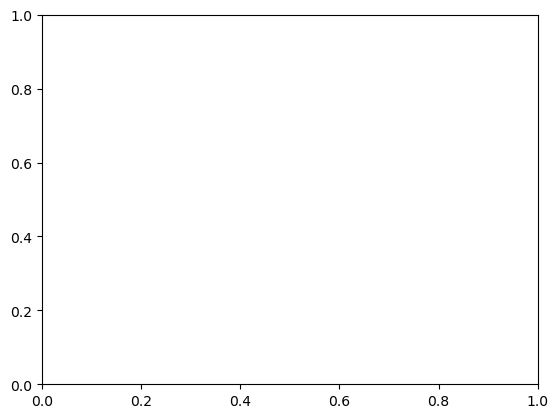

In [6]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes to Resolve Large, Randomly Generated Delegation Graphs")
plt.show()

In [ ]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

In [ ]:
# --- First plot: Regular scale ---
plt.figure()
plt.plot(x, times_le, label="LS Solver")
plt.plot(x, times_lp, label="LP Solver")
plt.plot(x, times_iterative, label="Iterative")

plt.title("Runtimes on Large, Randomly Generated Delegation Graphs")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

# --- Second plot: Log-log scale ---
plt.figure()
plt.loglog(x, times_le, label="LS Solver")
plt.loglog(x, times_lp, label="LP Solver")
plt.loglog(x, times_iterative, label="Iterative")

plt.title("Runtimes (Log-Log Scale)")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


In [ ]:
y = times_le[1:]

results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_le = pd.DataFrame(results).T

print("Results for LS:")
display(df_results_le)

y = times_lp[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_lp = pd.DataFrame(results).T

print("Results for LP:")
display(df_results_lp)


y = times_iterative[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_iterative = pd.DataFrame(results).T

print("Results for Iterative:")
display(df_results_iterative)

In [ ]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative")  


plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms on a Large Delegation Graph")
plt.show()

# --- First plot: Regular scale ---
le_pred = np.exp(df_results_le.loc['Power law'].loc['intercept']) *  (np.array(x) ** df_results_le.loc['Power law'].loc['slope'])
lp_pred = df_results_lp.loc['Linear'].loc['slope'] * np.array(x) + df_results_lp.loc['Linear'].loc['intercept']
lp_pred_power = np.exp(df_results_lp.loc['Power law'].loc['intercept']) * (np.array(x) ** df_results_lp.loc['Power law'].loc['slope'])

plt.figure()
plt.plot(x, times_le, label="LS Solver")
plt.plot(x, times_lp, label="LP Solver")
plt.plot(x, le_pred, label="LS fit")
plt.plot(x, lp_pred, label="LP fit linear")
plt.plot(x, lp_pred_power, label="LP fit power")
#plt.plot(x, times_iterative, label="Iterative")

plt.title("Runtime")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

# --- Second plot: Log-log scale ---
plt.figure()
plt.plot(x[1:], times_le[1:], label="LS Solver")
plt.plot(x[1:], times_lp[1:], label="LP Solver")
#plt.loglog(x, times_iterative, label="Iterative")

plt.loglog()
plt.title("Runtime (Log-Log Scale)")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


In [ ]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

In [10]:
delegations_orig, nodes = graph_gen.create_delegation_graph(40, seed=0)
viz.visualize_delegation_graph(delegations_orig)

Parsing the data...Done
Parsing the data...Done


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2' '4' '4' '4' '5' '8' '8' '9' '10' '10' '11' '12' '12' '12' '15' '15'
 '18' '18' '19' '20' '20' '20' '21' '21' '22' '24' '24' '25' '25' '25'
 '26' '26' '28' '28' '29' '29' '30' '30' '31' '31' '32' '33' '33' '34'
 '34' '35' '35' '36' '38' '39']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['22' '33' '30' '21' '26' '28' '23' '39' '32' '29' '8' '25' '9' '5' '29'
 '2' '15' '12' '13' '39' '18' '17' '25' '18' '7' '20' '4' '20' '15' '1'
 '32' '15' '26' '23' '26' '3' '11' '2' '15' '14' '3' '29' '7' '28' '26'
 '22' '13' '28' '3' '28

Graph visualization failed because no ports were found or there was another error.


No trigger
